In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from scipy.sparse import coo_matrix
from numba import jit, prange

# Summary

Performance of different methods:

| Method | Time (ms)  |
|--------|------------|
| scipy.sparse.coo_matrix.dot      | 650 |
| scipy.sparse.csr_matrix.dot      | 1000|
| scipy.sparse.csc_matrix.dot      | 1000|
| **Numba loop for COO algorithm** |**450**|
| **Numba parallel loop (2 cores)**|**200**|
| Cython loop for COO algorithm    | 800 |
| ESMPy native method              | 3000 |

Data used for the benchmark:

| Data   | grid size | extra dim | flattened shape | size  | I/O time (ms)  |
|--------|-----------|-----------|-----------------|-------| -------------- |
| Input  | 600x400   | 500       | 500x240000      | 1 GB  | 600  | 
| Output | 400x300   | 500       | 500x120000      | 0.5 GB| 250  |

**Key points:**

- All Python methods (Scipy/Numba/Cython) are much faster than ESMPy's original Fortran regridding engine ([ESMPy timing](http://xesmf.readthedocs.io/en/latest/Backend.html)). Thus xESMF must have its own regridding backend, instead of completely relying on ESMPy.
- Given Numba's excellent serial and parallel performance, we plan to use it as the default backend for xESMF in the next version.
- The regridding efficiency is getting close to I/O efficiency, so further optimizing regridding cannot significantly speed-up the entire workflow.

# Prepare data

## Sparse matrix

Read a typical weight file generated by ESMPy.

In [2]:
ds = xr.open_dataset("weights.nc")
ds

<xarray.Dataset>
Dimensions:  (n_s: 480000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

In [3]:
n_s = ds.dims['n_s']
col = ds['col'].values - 1
row = ds['row'].values - 1
S = ds['S'].values

In [4]:
A = coo_matrix((S, (row, col))) 
A.shape

(120000, 240000)

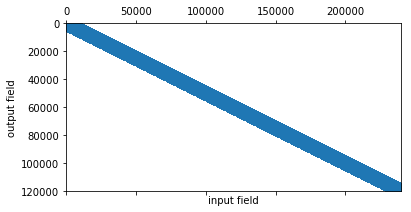

In [5]:
plt.spy(A)
plt.xlabel('input field')
plt.ylabel('output field')

## Data

The input grid size is `Nlat*Nlon=400*600=240000`. The size of additional dimension if 500 (think of `Ntime*Nlev`).

In [6]:
data = np.random.rand(500, A.shape[1])
data.shape

(500, 240000)

The output grid size is `Nlat*Nlon=300*400=120000`. 

In [7]:
# placeholder for numba/cython input
data_out = np.zeros([data.shape[0], A.shape[0]])
data_out.shape

(500, 120000)

In [8]:
# data size in GB
data.nbytes/1e9, data_out.nbytes/1e9

(0.96, 0.48)

## Test I/O efficiency

In real workflow, users typically read input data from disk and then dump regridding results to disk. Making the regridding calculation too much faster than I/O will have little benefit on the overall efficiency.

In [9]:
xr.DataArray(data).to_netcdf('data_in.nc')

In [10]:
%timeit xr.open_dataarray('data_in.nc').load()

621 ms ± 7.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit xr.DataArray(data_out).to_netcdf('data_out.nc')

245 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# scipy.sparse dot


## Common memory order

In [12]:
# convert COO format to other formats
A_csc = A.tocsc()
A_csr = A.tocsr()

To perform `A.dot()` on data, we need to pass the transpose so their shapes agree.

In [13]:
out_scipy = A.dot(data.T).T  # record results for later reference
out_scipy.shape

(500, 120000)

COO is faster than CSC/CSR, contradicts the common belief that CSC/CSR are more efficient for matrix multiplication.

In [14]:
%timeit A.dot(data.T).T
%timeit A_csc.dot(data.T).T
%timeit A_csr.dot(data.T).T

654 ms ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.19 s ± 94.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Memory order matters.** The input argument `data.T` is Fortran-ordered.

In [15]:
data.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

## Reversed memory order

If `data.T` is C-ordered, then CSC/CSR will be much faster than COO.

In [16]:
data_T = data.T.copy()  # make a C-ordered copy

In [17]:
data_T.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False

In [18]:
%timeit A.dot(data_T).T
%timeit A_csc.dot(data_T).T
%timeit A_csr.dot(data_T).T

3.21 s ± 57.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
367 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
377 ms ± 8.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Scipy summary

For most NetCDF data, the grid dimensions (lat and lon) are the fastest-changing dimensions. For example, the shape could be `(Ntime, Nlev, Nlat, Nlon)` (C-ordered). We flatten it to `(Ntime*Nlev, Nlat*Nlon)` (still C-ordered), then pass the tranpose `(Nlat*Nlon, Ntime*Nlev)` (Fortran-ordered) for `A.dot()` operation. Thus COO format should be used for most NetCDF data.

The internal code for [`scipy.sparse.coo_matrix.dot`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.dot.html) is a **just a plain algorithm written in C++**, without any specialize library
: [scipy/coo.h](https://github.com/scipy/scipy/blob/master/scipy/sparse/sparsetools/coo.h#L144).

Thus we replicate the same algorithm with Numba/Cython, and try to parallelize it.

# Numba

## Serial

In [19]:
@jit(nopython=True)
def sparse_dot(data_out, data, col, row, S):
    data_out[...] = 0.0
    for j in range(data.shape[0]):
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

sparse_dot(data_out, data, col, row, S); # compile jit

In [20]:
# exactly the same as Scipy result
np.array_equal(data_out, out_scipy)

True

**Numba turns out to be ~20% faster than Scipy.**

In [21]:
%timeit sparse_dot(data_out, data, col, row, S)

453 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## parallel

In [22]:
@jit(nopython=True, parallel=True)
def sparse_dot_parallel(data_out, data, col, row, S):
    for j in prange(data.shape[0]):
        data_out[j, :] = 0.0
        for i in range(S.size):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

sparse_dot_parallel(data_out, data, col, row, S); # compile jit

In [23]:
np.array_equal(data_out, out_scipy)

True

In [24]:
%timeit sparse_dot_parallel(data_out, data, col, row, S)

203 ms ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parallelization on my dual-core Mac gives 2x speed-up. Regridding now takes almost the same time as I/O.

# Cython

In [25]:
%load_ext Cython

In [26]:
%%cython
cimport cython

@cython.boundscheck(False)
cpdef cython_dot(double[:, :] data_out, double[:, :] data, 
                 int[:] col, int[:] row, double[:] S):
    cdef int i, j 
    data_out[...] = 0.0
    for j in range(data.shape[0]):
        for i in range(S.shape[0]):
            data_out[j, row[i]] += data[j, col[i]]*S[i]

In [27]:
# exactly the same as Scipy result
cython_dot(data_out, data, col, row, S)
np.array_equal(data_out, out_scipy)

True

Cython is 40% slower than Scipy. There could be some room for optimization, though.

In [28]:
%timeit cython_dot(data_out, data, col, row, S)

793 ms ± 9.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
